# Импортируем необходимые библиотеки

In [1293]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
RANDOM_SEED = 42

# Откройте файл с данными

In [1294]:
columns = ["calls",  "minutes",  "message","md_used", "is_ultra"]
df_tarific = pd.read_csv("users_behavior.csv",
                 names=columns,
                 header=1) 

In [1295]:
df_tarific.head()

,calls,minutes,message,md_used,is_ultra
0,85.0,516.75,56.0,22696.96,0
1,77.0,467.66,86.0,21060.45,0
2,106.0,745.53,81.0,8437.39,1
3,66.0,418.74,1.0,14502.75,0
4,58.0,344.56,21.0,15823.37,0


In [1296]:
df_tarific.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3213 non-null   float64
 1   minutes   3213 non-null   float64
 2   message   3213 non-null   float64
 3   md_used   3213 non-null   float64
 4   is_ultra  3213 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.6 KB


In [1297]:
df_tarific.describe()

,calls,minutes,message,md_used,is_ultra
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,63.046063,438.248098,38.267351,17206.831089,0.306567
std,33.239054,234.595795,36.145338,7571.995923,0.461140
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.530000,9.000000,12491.750000,0.000000
50%,62.000000,430.700000,30.000000,16942.030000,0.000000
75%,82.000000,572.030000,57.000000,21425.840000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Вывод: 
1. Пропущенных значений нет
1. Типы столбцов в порядке
1. Дубликатов нет

<div class="alert alert-info">
<b>как по мне - очень удобно смотреть именно транспонированное значение дескрайба, может пригодиться:</b>
</div>

Исследовательский анализ данных

<Axes: >

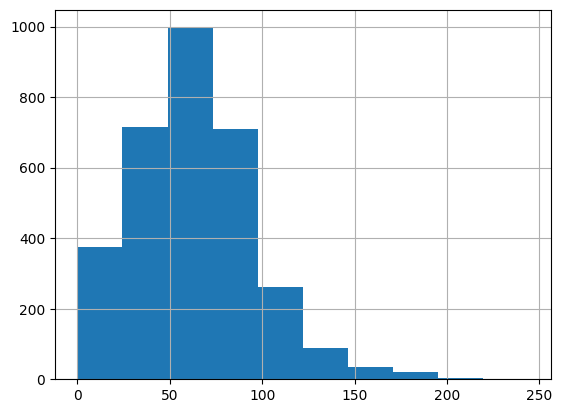

In [1298]:
df_tarific['calls'].hist()

Данные в разрезе тарифов

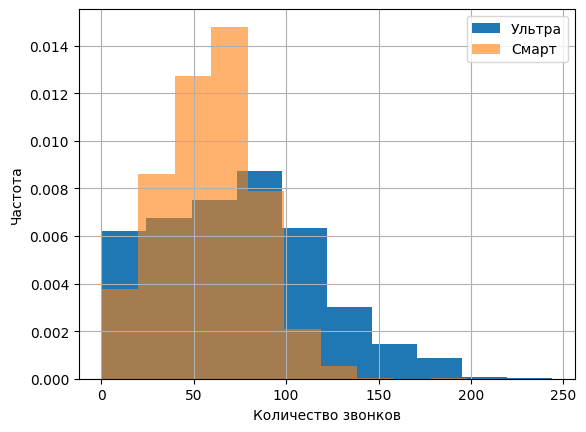

In [1299]:
df_tarific.query('is_ultra == 1')['calls'].hist(density=True)
df_tarific.query('is_ultra == 0')['calls'].hist(density=True, alpha=0.6)

plt.xlabel("Количество звонков")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: На основе данной гистограммы можно отметить, что тариф "Смарт" пользуется меньшей популярностью по сравнению с тарифом "Ультра", как видно из относительных частот. Однако, несмотря на меньшую популярность, пользователи тарифа "Смарт" проявляют более активное поведение в совершении звонков, что отражено в более высокой частоте использования количества звонков. </font>
    </b>
</div>

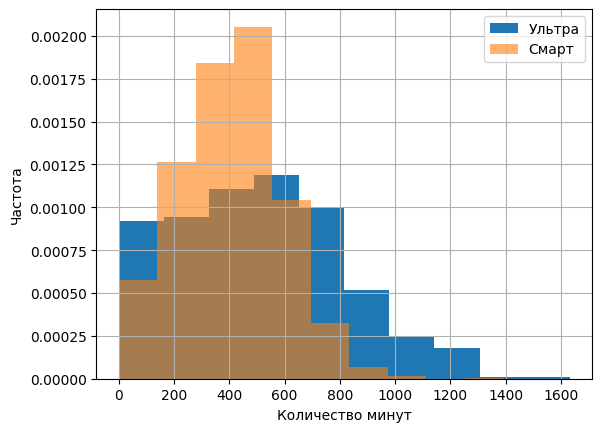

In [1300]:
df_tarific.query('is_ultra == 1')['minutes'].hist(density=True)
df_tarific.query('is_ultra == 0')['minutes'].hist(alpha=0.6, density=True)

plt.xlabel("Количество минут")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()

In [1301]:
correlation = df_tarific.query('is_ultra == 1')['calls'].corr(df_tarific.query('is_ultra == 1')['minutes'])
print(f"Correlation between 'calls' for 'is_ultra == 1' and 'minutes' for 'is_ultra == 1': {correlation:.2f}")


Correlation between 'calls' for 'is_ultra == 1' and 'minutes' for 'is_ultra == 1': 0.99



<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: Как можно заметить количество минут и колличество звонков кореллируют между собой. </font>
    </b>
</div>

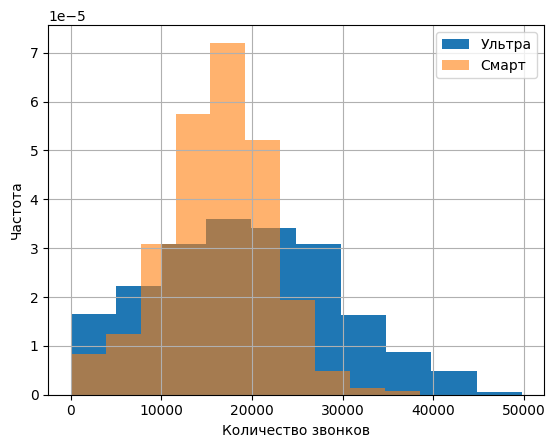

In [1302]:
df_tarific.query('is_ultra == 1')['md_used'].hist(density=True)
df_tarific.query('is_ultra == 0')['md_used'].hist(alpha=0.6, density=True)

plt.xlabel("Количество звонков")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: Пользователе тарифа "Смарт" намного чаше потребляют интернет трафик. Как показано пик частоты использования приходяться от 10 до 25 Гб.</font>
    </b>
</div>

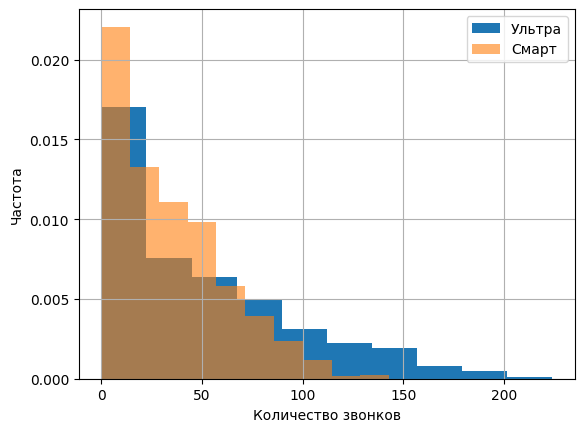

In [1303]:
df_tarific.query('is_ultra == 1')['message'].hist(density=True)
df_tarific.query('is_ultra == 0')['message'].hist(alpha=0.6, density=True)

plt.xlabel("Количество звонков")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()

In [1304]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_tarific['is_ultra'], df_tarific['message'])

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")

Chi-square test statistic: 465.18887183342
P-value: 2.4735242682804427e-27


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: результаты показывают, что клиенты тратят на сообщение меньше всего. Частота использования при 0 самая высокая.</font>
    </b>
</div>


<div class="alert alert-warning">
<b>здорово, что данные визуализировал - не хватает только выводов по графикам. хотя бы пару слов.</b>
</div>

In [1305]:
df_tarific.query('is_ultra == 1').describe()

,calls,minutes,message,md_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


In [1306]:
df_tarific.query('is_ultra == 0').describe()

,calls,minutes,message,md_used,is_ultra
count,2228.000000,2228.000000,2228.000000,2228.000000,2228.0
mean,58.471724,405.985162,33.361759,16206.803146,0.0
std,25.942730,184.543262,28.214621,5871.291048,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.130000,10.000000,12638.732500,0.0
50%,60.000000,410.605000,28.000000,16505.565000,0.0
75%,76.000000,529.515000,51.000000,20043.907500,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


<Axes: >

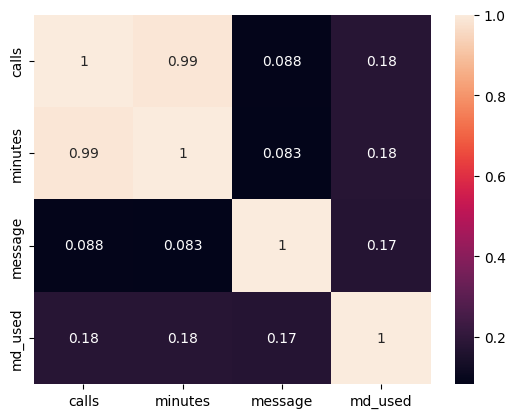

In [1307]:
sns.heatmap(df_tarific.query('is_ultra == 1').drop('is_ultra', axis=1).corr(), annot=True)

<Axes: >

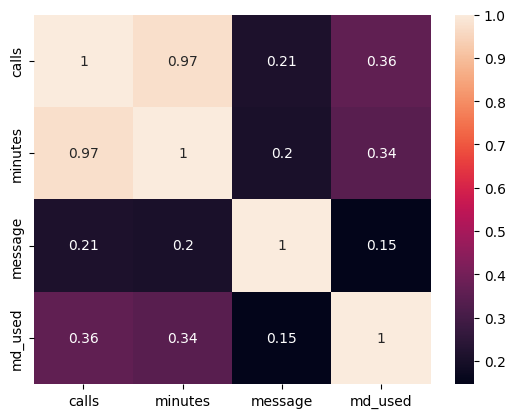

In [1308]:
sns.heatmap(df_tarific.query('is_ultra == 0').drop('is_ultra', axis=1).corr(), annot=True)

<div class="alert alert-warning">
<b>выводы?</b>
</div>


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: Смотря на матрицу корреляции можно сказать, что наибольшая корреляция у параметров тарифов является между колличеством звонков и минутами и составляет около 0.97. </font>
    </b>
</div>


<div class="alert alert-info">
<b> смотри, звонки и минуты сильно скореллированы. можно попробовать стратегии: </b>

1. удалить или один, или другой. чтобы понять какой удалить можно либо в тупую попробовать, либо воспользоваться расчетом VIF, либо каким нибудь PCA.

2. объединить признаки - это называется feature engineering. то есть по сути придумать формулу, объединяющую эти два признака в один


полезные статьи по теме:

https://stats.stackexchange.com/questions/361020/why-is-multicollinearity-so-bad-for-machine-learning-models-and-what-can-we-do-a
https://habr.com/ru/companies/akbarsdigital/articles/592493/
https://medium.com/analytics-vidhya/removing-multi-collinearity-for-linear-and-logistic-regression-f1fa744f3666
https://towardsdatascience.com/how-to-remove-multicollinearity-in-dataset-using-pca-4b4561c28d0b
https://machinelearningmastery.com/information-gain-and-mutual-information/


</div>

# Разобьем данные на выборки

In [1309]:
X = df_tarific.drop(columns=['is_ultra']) 
Y = df_tarific['is_ultra']

Проверка и обработка дисбаланса классов

In [1310]:
# counter = Counter(Y)
# print(counter)


# if counter[0] > counter[1]:
 
#     smote = SMOTE(random_state=42)
#     X, Y = smote.fit_resample(X, Y)

Проверка мультиколлинеарности

удаление высококоррелированных признаков с корреляцией более 0.9

In [1311]:
corr_matrix = X.corr()
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

df_tarific_filtered = X.drop(columns=high_corr_features)

In [1312]:
df_tarific_filtered 

,calls,message,md_used
0,85.0,56.0,22696.96
1,77.0,86.0,21060.45
2,106.0,81.0,8437.39
3,66.0,1.0,14502.75
4,58.0,21.0,15823.37
...,...,...,...
3208,122.0,20.0,35124.90
3209,25.0,0.0,3275.61
3210,97.0,70.0,13974.06
3211,64.0,90.0,31239.78


Масштабирование признаков  

In [1313]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_tarific_filtered)

In [1314]:
X_scaled

array([[ 0.66058902,  0.49066933,  0.72516989],
       [ 0.41987082,  1.32078107,  0.50900962],
       [ 1.29247428,  1.18242911, -1.15832155],
       ...,
       [ 1.02166631,  0.87805481, -0.42700423],
       [ 0.02870375,  1.43146263,  1.85355794],
       [ 0.51014015, -0.89285024,  1.6211841 ]])

Разделение на обучающий, валидационный и тестовый наборы

In [1315]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, Y, test_size=0.33, random_state=RANDOM_SEED)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

In [1316]:
pd.DataFrame(X_train)

,0,1,2
0,0.419871,-1.058873,0.248838
1,-1.084618,-0.118079,-0.737001
2,-0.001386,-0.477794,0.270491
3,1.713731,-0.892850,2.415998
4,1.021666,1.182429,-0.291953
...,...,...,...
2147,-1.445695,-0.892850,-1.898446
2148,-1.445695,-0.533135,-1.705606
2149,1.262385,-0.782169,2.116918
2150,-0.603182,-0.477794,0.596486


<div class="alert alert-warning">
<b>дисбаланс классов? мультиколлинеарность? масштабирование признаков? все это может поднять тебе качество моделей</b>
</div>

#  Исследуем модели

# Random Forest

In [1317]:
best_RF = None
best_accuracy_RF = 0
best_est_RF = 0
best_depth_RF = 0

<div class="alert alert-info">
в ML постоянно могут мешать надоедливые warnings, это можно отключить так:

In [1318]:
import warnings
warnings.filterwarnings('ignore')

In [1319]:
for est in range(2, 51):
    for depth in range(2, 25):
        
        RF = RandomForestClassifier(random_state = RANDOM_SEED, n_estimators = est, max_depth = depth)
        RF.fit(X_train, y_train)
        
        prediction_valid_RF = RF.predict(X_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)

        if best_accuracy_RF < accuracy_RF:
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF

Результаты работы:

accuracy

In [1320]:
print(f"Random Forest accuracy_score valid: {best_accuracy_RF}")

Random Forest accuracy_score valid: 0.8132075471698114


In [1321]:
prediction_test_RF = best_RF.predict(X_test)

In [1322]:
accuracy_RF_test = accuracy_score(prediction_test_RF, y_test)
print(f"Random Forest accuracy_score test: {accuracy_RF_test}")

Random Forest accuracy_score test: 0.8116760828625236


f1_score

In [1323]:
f1_score_RF_valid = f1_score(prediction_valid_RF, y_valid, average='weighted')
print(f"Random Forest f1_score test: {f1_score_RF_valid}")

Random Forest f1_score test: 0.7987781199422123


In [1324]:
f1_score_RF_test = f1_score(prediction_test_RF, y_test, average='weighted')
print(f"Random Forest f1_score test: {f1_score_RF_test}")

Random Forest f1_score test: 0.818568731500296



<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: Исходя из предоставленных метрик оценки вашей модели случайного леса, можно сделать следующие выводы:

Показатели точности:

Точность на валидационной выборке составляет приблизительно 81,32%.
Точность на тестовой выборке составляет приблизительно 81,17%.
Показатель точности в данном случае модель показывает схожую хорошую производительность как на валидационной, так и на тестовой выборке, что указывает на последовательность результатов.

Показатели F1:

F1-мера на тестовой выборке составляет приблизительно 79,88%.
F1-мера на валидационной выборке составляет приблизительно 81,86%.
F1-скор на валидационной выборке выше, чем на тестовой выборке, что может свидетельствовать о некотором переобучении модели на тренировочных данных.

Точность и F1-скор находятся на приемлемом уровне, что указывает на хорошую общую производительность модели.

 </font>
    </b>
</div>


# Decision Tree

In [1325]:
best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0

In [1326]:
for depth in range(2,5):
    DT = DecisionTreeClassifier(random_state = RANDOM_SEED, max_depth = depth)
    DT = DT.fit(X_train, y_train)
    prediction_valid_DT = DT.predict(X_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, y_valid)
    if best_accuracy_DT < accuracy_DT:
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth

Вывод 

In [1327]:
from sklearn import tree

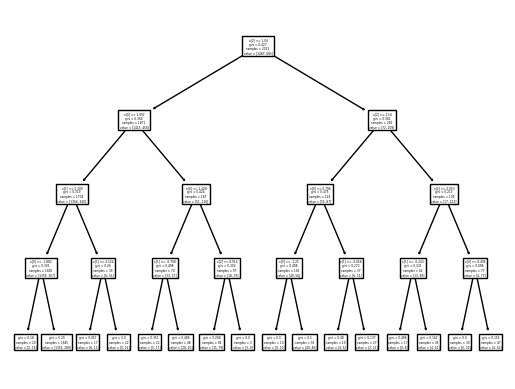

In [1328]:
tree.plot_tree(DT);

<div class="alert alert-info">
чтобы спрятать вспомогательный вывод к графику достаточно поставить ; в конце, обрати внимание

<div class="alert alert-warning">
<b>выводы?</b>
</div>

accuracy

In [1342]:
print(f"Decision Tree valid accuracy_score: {best_accuracy_DT}")

Decision Tree valid accuracy_score: 0.7867924528301887


In [1330]:
prediction_test_DT = best_DT.predict(X_test)

In [1341]:
accuracy_DT_test = accuracy_score(prediction_test_DT, y_test)
print(f"Decision Tree test accuracy_score: {accuracy_DT_test}")

Decision Tree test accuracy_score: 0.7815442561205274


f1_score

In [1344]:
f1_score_DT_valid = f1_score(prediction_valid_DT, y_valid, average='weighted')

print(f"Decision Tree valid f1_score: {f1_score_DT_valid}")

Decision Tree valid f1_score: 0.8111394401730758


In [1343]:
f1_score_DT_test = f1_score(prediction_test_DT, y_test, average='weighted')
print(f"Decision Tree test f1_score: {f1_score_DT_test}")

Decision Tree test f1_score: 0.8039214420231369



<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: 
Точность на тестовой и валидационной выборках:

Точность на тестовой выборке составляет приблизительно 78,15%.
Точность на валидационной выборке составляет приблизительно 78,68%.
Модель дерева решений показывает сопоставимую производительность на тестовой и валидационной выборках.

F1-скор на тестовой и валидационной выборках:

F1-скор на тестовой выборке составляет приблизительно 80,39%.
F1-скор на валидационной выборке составляет приблизительно 81,11%.
Значения F1-скора говорят о том, что модель показывает неплохие результаты, особенно на валидационной выборке.

Точность и F1-скор находятся на уровне, который может считаться приемлемым.
 </font>
    </b>
</div>


# LogisticRegression

In [1334]:
LR = LogisticRegression(random_state = RANDOM_SEED, max_iter= 1000, tol=1e-5, solver = 'lbfgs')
LR.fit(X_train, y_train)
prediction_valid_LR = LR.predict(X_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, y_valid)

Вывод

accuracy

In [1345]:
print(f"Logistic Regression valid accuracy_score: {accuracy_LR}")

Logistic Regression valid accuracy_score: 0.7433962264150943


In [1336]:
prediction_test_LR = LR.predict(X_test)

In [1337]:
accuracy_LR_test = accuracy_score(prediction_test_LR, y_test)

In [1346]:
print(f"Logistic Regression test accuracy_score: {accuracy_LR_test}")

Logistic Regression test accuracy_score: 0.7476459510357816


f1_score

In [1350]:
f1_score_LR_valid = f1_score(prediction_valid_LR, y_valid, average='weighted')
print(f"Logistic Regression test f1_score: {f1_score_LR_valid}")

Logistic Regression test f1_score: 0.7987571180920704


In [1351]:
f1_score_LR_test = f1_score(prediction_test_LR, y_test, average='weighted')

print(f"Logistic Regression test f1_score: {f1_score_LR_test}")

Logistic Regression test f1_score: 0.7917084610751828



<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: 
Точность на тестовой и валидационной выборках:

Точность на тестовой выборке составляет приблизительно 74,76%.
Точность на валидационной выборке составляет приблизительно 74,34%.
Модель логистической регрессии показывает сопоставимую производительность на тестовой и валидационной выборках.

F1-скор на тестовой и валидационной выборках:

F1-скор на тестовой выборке составляет приблизительно 79,18%.
F1-скор на валидационной выборке составляет приблизительно 79,88%.
Значения F1-скора говорят о том, что модель демонстрирует неплохие результаты на обеих выборках.

Общие наблюдения:

Точность и F1-скор находятся на уровне, который может считаться приемлемым.
Модель логистической регрессии показывает себя стабильно как на тестовой, так и на валидационной выборках.
 </font>
    </b>
</div>


<div class="alert alert-warning">
<b>в целом все хорошо, кроме отсутствующих выводов и вообще текста. если хочешь повысить качество - оставил подсказку</b>
</div>